In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
path ='/content/drive/MyDrive/Colab Notebooks/comments.xls' 

In [ ]:
# Read the data 
data = pd.read_excel(path)
data.head() 

,id,text,class_label
0,473,আল্লাহ অবশ্যই এদের পাশে থাকবে।,Positive
1,1954,বেগম খালেদা জিয়া সঠিক বলেছেন।,Positive
2,2145,ভারতীয় অনূর্ধ্ব-১৯ দলের কোচ ম্যাচ শেষে পাকিস্...,Positive
3,2250,খুব গুরুত্ব পূর্ন একটি ভাল সিদ্ধান্ত রাজ্জাক ভ...,Positive
4,4680,এই বাভে যদি সফর করা যেত মানুষ আর লক্ষ লক্ক টা...,Negative


In [ ]:

# Read the data and take only 1000 Reviews
data = pd.read_excel(path)
print("Total Reviews:",len(data),
      "\nTotal  Positive Reviews:",len(data[data.class_label=='Positive']),
      "\nTotal Negative Reviews:",len(data[data.class_label=='Negative']))

Total Reviews: 5252 
Total  Positive Reviews: 2241 
Total Negative Reviews: 3011


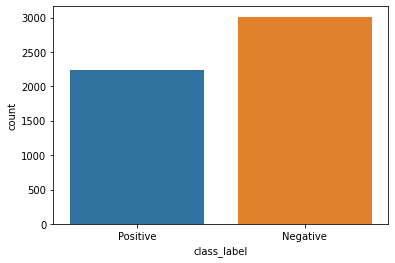

In [ ]:
sns.countplot(x="class_label",data=data)

In [ ]:
print("Description of TrainSet...")
data.describe()

Description of TrainSet...


,id
count,5252.000000
mean,3443.564547
std,1975.757615
min,2.000000
25%,1735.750000
50%,3478.500000
75%,5108.250000
max,6889.000000


In [ ]:
print("Dataframe Information on TrainSet...")
data.info()

Dataframe Information on TrainSet...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5252 entries, 0 to 5251
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5252 non-null   int64 
 1   text         5252 non-null   object
 2   class_label  5252 non-null   object
dtypes: int64(1), object(2)
memory usage: 123.2+ KB


In [ ]:
print("Categories:")
print(data.class_label.unique())
category_list=data.class_label.unique()

Categories:
['Positive' 'Negative']


In [ ]:
data.shape

(5252, 3)

In [ ]:
data.isnull().sum()

id             0
text           0
class_label    0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
# print some unprocessed reviews
sample_data = [2,3,4,5,6,40,50]
for i in sample_data:
      print(data.text[i],'\n','Sentiment:-- ',data.class_label[i],'\n')  

 ভারতীয় অনূর্ধ্ব-১৯ দলের কোচ ম্যাচ শেষে পাকিস্তানের ড্রেসিংরুমে গিয়ে সবাইকে সান্ত্বনা দিয়েছেন। 
 Sentiment:--  Positive 

খুব গুরুত্ব পূর্ন একটি ভাল সিদ্ধান্ত রাজ্জাক ভাইকে ফিরিয়ে আনার জন্য । 
 Sentiment:--  Positive 

 এই বাভে যদি সফর করা যেত মানুষ আর লক্ষ লক্ক টাকা করছ করে বিদেশে যেত না  
 Sentiment:--  Negative 

ছাব্বির তো মনে হয় গুণ্ডামি করতে মাঠে নামে। তারপর চোখে সরষে ফুল দেখে নিজেই অক্কা পায়। 
 Sentiment:--  Negative 

হাতুরে গংরা নিপাত যাক,প্রতিভা মুক্তি পাক। 
 Sentiment:--  Negative 

আশাকির সামনের খেলায় আমাদের জিতবো।  
 Sentiment:--  Positive 

 ঠেকানোর দরকারও মনে করসি না মামা পারলে তাদের হয়ে কথা বলুন নইলে চুপ থাকুন৷এরা যে ভারতীয় হাতী না তা আমরা জানি৷  
 Sentiment:--  Negative 



In [ ]:

# Data cleaning function
def process_comments(comment): 
    comment = re.sub('[^\u0980-\u09FF]',' ',str(comment)) #removing unnecessary punctuation
    return comment

In [ ]:

# Apply the function into the dataframe
data['cleaned'] = data['text'].apply(process_comments)  



Preprocessing/**Cleaning**

In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
data['cleaned'] = data.text.apply(lambda x: preprocessing(str(x)))

**Stopwords** **Removal**

In [ ]:
data1 =pd.read_excel('/content/drive/MyDrive/Colab Notebooks/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [ ]:
display(data1)


,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [ ]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [ ]:

data['cleaned'] = data.text.apply(lambda x: stopwordRemoval(str(x)))


**Stemming**

In [ ]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data['cleaned']=data['cleaned'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules.

**Removing** **Low** Length **Data**

In [ ]:
# Length of each Comment
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the Comment with least words
dataset = data.loc[data.length>1]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Reviews".format(len(data)-len(dataset)),
      "\nTotal Reviews:",len(dataset))

After Cleaning: 
Removed 31 Small Reviews 
Total Reviews: 5221


In [ ]:
dataset.class_label = dataset.class_label.replace({'Positive' 'Negative'})
positive = dataset[dataset.class_label == 'Positive']
negative = dataset[dataset.class_label == 'Negative'][:4000]
dataset = positive.append(negative,ignore_index=True)
dataset.class_label.value_counts()

Negative    2999
Positive    2222
Name: class_label, dtype: int64

In [ ]:
def label_encoding(sentiment,bool):

    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels


 ################# Dataset Splitting Function ###############
                          

def dataset_split(feature_space,sentiment):
    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
   # print("Feature Size :======>",X_train.shape[1])
    #print("\nDataset Distribution:\n")
   # print("\tSet Name","\t\tSize")
   # print("\t========\t\t======")

    #print("\tFull\t\t\t",feature_space.shape[0],
     #   "\n\tTraining\t\t",X_train.shape[0],
      #  "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test


Model Building Using Machine Learning

Feature Extraction Using TF-IDF


In [ ]:
def calc_gram_tfidf(comments,gram):

    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(comments)
    
    return tfidf,X

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
model_acc={}

Model Training

In [ ]:

## save the performance of the model for each gram feature 
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]
for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(dataset.cleaned,gram)

    labels = label_encoding(dataset.class_label,False)
    X_train,X_test,y_train,y_test = dataset_split(feature,labels) 


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
svc_model = SVC()
svc_model.fit(X_train,y_train) 
y_pred = svc_model.predict(X_test)
model_acc["SVC"]=accuracy_score(y_true=y_test,y_pred=y_pred)*100
print(accuracy_score(y_true=y_test,y_pred=y_pred)*100)


75.33460803059273


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       309
           1       0.92      0.43      0.59       214

    accuracy                           0.75       523
   macro avg       0.82      0.70      0.71       523
weighted avg       0.80      0.75      0.73       523



In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred))

[[301   8]
 [121  93]]


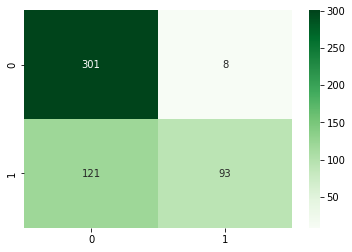

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="1.0f",cmap="Greens")

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# y_true is the true labels of your data, and y_pred is the predicted labels
# assuming they are both in the form of 1D arrays/lists
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))


Precision: 0.80
Recall: 0.75
F1-score: 0.73


In [ ]:
from sklearn.metrics import accuracy_score
mnb= MultinomialNB()
mnb.fit(X_train,y_train) 
y_pred = mnb.predict(X_test)
model_acc["MNB"]=accuracy_score(y_true=y_test,y_pred=y_pred)*100
accuracy_score(y_true=y_test,y_pred=y_pred)*100

80.68833652007649

In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       309
           1       0.88      0.61      0.72       214

    accuracy                           0.81       523
   macro avg       0.83      0.78      0.79       523
weighted avg       0.82      0.81      0.80       523



In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred))

[[292  17]
 [ 84 130]]


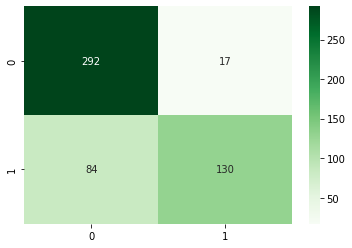

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="1.0f",cmap="Greens")

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# y_true is the true labels of your data, and y_pred is the predicted labels
# assuming they are both in the form of 1D arrays/lists
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

Precision: 0.82
Recall: 0.81
F1-score: 0.80


In [ ]:
from sklearn.metrics import accuracy_score
lgr = LogisticRegression()
lgr.fit(X_train,y_train) 
y_pred = lgr.predict(X_test)
model_acc["LR"]=accuracy_score(y_true=y_test,y_pred=y_pred)*100
accuracy_score(y_true=y_test,y_pred=y_pred)*100

77.62906309751433

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# y_true is the true labels of your data, and y_pred is the predicted labels
# assuming they are both in the form of 1D arrays/lists
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

Precision: 0.81
Recall: 0.78
F1-score: 0.76


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       309
           1       0.92      0.50      0.64       214

    accuracy                           0.78       523
   macro avg       0.83      0.73      0.74       523
weighted avg       0.81      0.78      0.76       523



In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred))

[[300   9]
 [108 106]]


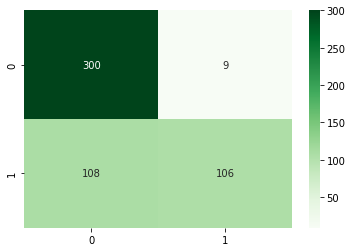

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="1.0f",cmap="Greens")

In [ ]:
from sklearn.metrics import accuracy_score
RFC =RandomForestClassifier()
RFC.fit(X_train,y_train) 
y_pred = RFC.predict(X_test)
model_acc["RF"]=accuracy_score(y_true=y_test,y_pred=y_pred)*100
accuracy_score(y_true=y_test,y_pred=y_pred)*100


76.2906309751434

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# y_true is the true labels of your data, and y_pred is the predicted labels
# assuming they are both in the form of 1D arrays/lists
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

Precision: 0.78
Recall: 0.76
F1-score: 0.75


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82       309
           1       0.86      0.50      0.64       214

    accuracy                           0.76       523
   macro avg       0.80      0.72      0.73       523
weighted avg       0.78      0.76      0.75       523



In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred))

[[291  18]
 [106 108]]


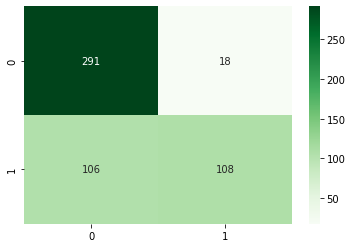

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="1.0f",cmap="Greens")

In [ ]:
from sklearn.metrics import accuracy_score
DTC =DecisionTreeClassifier()
DTC.fit(X_train,y_train) 
y_pred = DTC.predict(X_test)
model_acc["DT"]=accuracy_score(y_true=y_test,y_pred=y_pred)*100
accuracy_score(y_true=y_test,y_pred=y_pred)*100

71.31931166347992

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# y_true is the true labels of your data, and y_pred is the predicted labels
# assuming they are both in the form of 1D arrays/lists
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

Precision: 0.71
Recall: 0.71
F1-score: 0.71


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       309
           1       0.67      0.58      0.62       214

    accuracy                           0.71       523
   macro avg       0.70      0.69      0.70       523
weighted avg       0.71      0.71      0.71       523



In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred))

[[248  61]
 [ 89 125]]


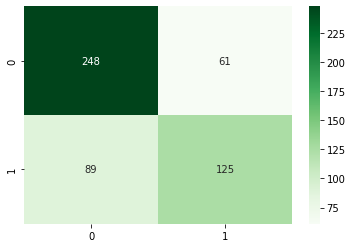

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="1.0f",cmap="Greens")

In [ ]:
from sklearn.metrics import accuracy_score
KNN =KNeighborsClassifier()
KNN.fit(X_train,y_train) 
y_pred = KNN.predict(X_test)
model_acc["KNN"]=accuracy_score(y_true=y_test,y_pred=y_pred)*100
accuracy_score(y_true=y_test,y_pred=y_pred)*100

75.33460803059273

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# y_true is the true labels of your data, and y_pred is the predicted labels
# assuming they are both in the form of 1D arrays/lists
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

Precision: 0.76
Recall: 0.75
F1-score: 0.76


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       309
           1       0.67      0.77      0.72       214

    accuracy                           0.75       523
   macro avg       0.75      0.76      0.75       523
weighted avg       0.76      0.75      0.76       523



In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred))

[[229  80]
 [ 49 165]]


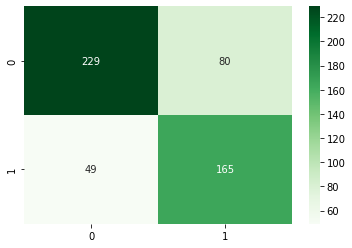

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="1.0f",cmap="Greens")

In [ ]:
from sklearn.metrics import accuracy_score
SGC =SGDClassifier()
SGC.fit(X_train,y_train) 
y_pred = SGC.predict(X_test)
model_acc["SGC"]=accuracy_score(y_true=y_test,y_pred=y_pred)*100
accuracy_score(y_true=y_test,y_pred=y_pred)*100

82.79158699808795

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# y_true is the true labels of your data, and y_pred is the predicted labels
# assuming they are both in the form of 1D arrays/lists
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred, average='weighted')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

Precision: 0.83
Recall: 0.83
F1-score: 0.83


In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       309
           1       0.82      0.74      0.78       214

    accuracy                           0.83       523
   macro avg       0.83      0.81      0.82       523
weighted avg       0.83      0.83      0.83       523



In [ ]:
print(confusion_matrix(y_true=y_test,y_pred=y_pred))

[[275  34]
 [ 56 158]]


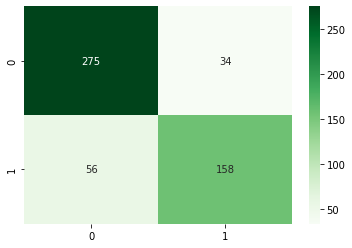

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_pred),annot=True,fmt="1.0f",cmap="Greens")

In [ ]:
import pickle as pk
with open('my_model7.pkl','wb') as file:
  pk.dump(SGC,file)

In [ ]:
import pickle as pk
with open('my_model7.pkl','rb') as file:
  model7=pk.load(file)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cv_score=cross_val_score(SGC,feature,labels,cv=10)

In [ ]:
cv_score

array([0.83173996, 0.81226054, 0.80651341, 0.79118774, 0.81417625,
       0.82950192, 0.82950192, 0.77777778, 0.81034483, 0.81034483])

In [ ]:
model_scores = pd.DataFrame(model_acc, index=['Score']).transpose()

In [ ]:
model_scores = model_scores.reset_index().rename({"index":"Algorithms"}, axis = 1)



In [ ]:
model_scores

,Algorithms,Score
0,SVC,75.334608
1,MNB,80.688337
2,LR,77.629063
3,RF,76.290631
4,DT,71.319312
5,KNN,75.334608
6,SGC,82.791587


Text(0, 0.5, 'Score')

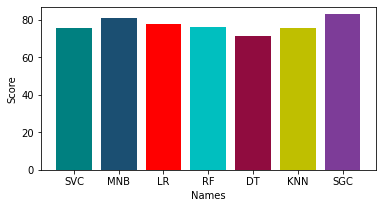

In [ ]:
namess = list(model_acc.keys())
valuess = list(model_acc.values())
colors = ['teal', '#1B4F72', 'r', 'c', '#900C3F', 'y','#7D3C98']
textprops = {"fontsize":22}

plt.figure(figsize=(6,3))
plt.bar(namess,valuess,color=colors)
plt.xlabel("Names")
plt.ylabel("Score")

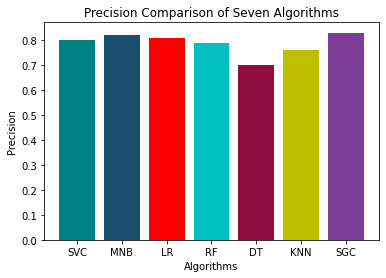

In [ ]:
import matplotlib.pyplot as plt

# create a list of algorithm names and a list of corresponding scores
algorithms = ['SVC', 'MNB', 'LR', 'RF', 'DT', 'KNN', 'SGC']
scores = [0.80, 0.82, 0.81, 0.79, 0.70, 0.76, 0.83]

# create a list of colors excluding black
colors = ['teal', '#1B4F72', 'r', 'c', '#900C3F', 'y','#7D3C98']

# create a bar chart with the algorithm names as x-axis and the scores as y-axis
plt.bar(algorithms, scores, color=colors)
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.title('Precision Comparison of Seven Algorithms')
plt.show()

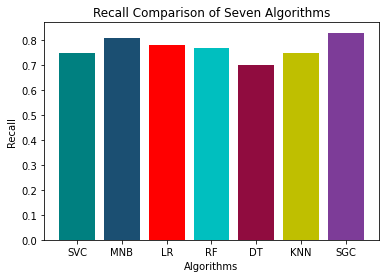

In [ ]:
import matplotlib.pyplot as plt

# create a list of algorithm names and a list of corresponding scores
algorithms = ['SVC', 'MNB', 'LR', 'RF', 'DT', 'KNN', 'SGC']
scores = [0.75, 0.81, 0.78, 0.77, 0.70, 0.75, 0.83]

# create a list of colors excluding black
colors = ['teal', '#1B4F72', 'r', 'c', '#900C3F', 'y','#7D3C98']

# create a bar chart with the algorithm names as x-axis and the scores as y-axis
plt.bar(algorithms, scores, color=colors)
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.title('Recall Comparison of Seven Algorithms')
plt.show()

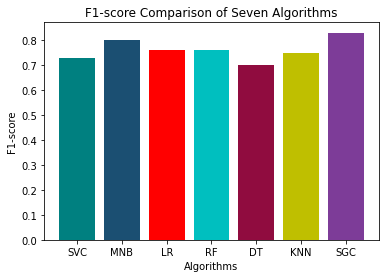

In [ ]:
import matplotlib.pyplot as plt

# create a list of algorithm names and a list of corresponding scores
algorithms = ['SVC', 'MNB', 'LR', 'RF', 'DT', 'KNN', 'SGC']
scores = [0.73, 0.80, 0.76, 0.76, 0.70, 0.75, 0.83]

# create a list of colors excluding black
colors = ['teal', '#1B4F72', 'r', 'c', '#900C3F', 'y','#7D3C98']

# create a bar chart with the algorithm names as x-axis and the scores as y-axis
plt.bar(algorithms, scores, color=colors)
plt.xlabel('Algorithms')
plt.ylabel('F1-score')
plt.title('F1-score Comparison of Seven Algorithms')
plt.show()

In [ ]:
def generate(text):
  
  #text=str(text)
  text =process_comments(text)
  text=stopwordRemoval(text)
  text=preprocessing(text)
  text=stem_text(text)
  return " ".join(text)

In [ ]:
t=generate("মনে হচ্ছে এই জায়গাটি স্থানীয়দের মতো এবং এখানে যারা কাজ করছে তারাও এটি পছন্দ করে।")

X = tfidf.transform([t])
output=model7.predict(X)

applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..


In [ ]:
# generate the prediction
if output == 1:
  print("positive")
else:
  print("negative")

negative
